# Recommender (Empfehlungs-) Systeme

Willkommen zum Code-Notebook zur Lektion über Empfehlungssysteme (en. recommender systems). In dieser Lektion werden wir ein einfaches Empfehlungssystem mit Python und Pandas erstellen. Zusätzlich gibt es ein zweites Notebook *Fortgeschrittene Empfehlungssysteme mit Python*, indem wir ein komplexeres Empfehlungssystem für den gleichen Datensatz erstellen.

In diesem Notebook geht es daraum ein einfaches funktionierendes Empfehlungssystem zu erstellen, dass Items empfiehlt, die möglichst ähnlich zu einem bestimmten Item sind. In unserem Fall wird es sich um Filme handeln. Denkt aber bitte daran, dass dies kein ausgeklügeltes reales Empfehlungssystem ist; es sagt uns einfach nur, welche Filme sich in ihren Eigenschaften ähneln. Netflix und Co. beziehen das Nutzerverhalten und viel mehr Eigenschaften für ihre Empfehlungen.

Es gibt zu diesem Thema kein Projekt, aber jeder der möchte kann das fortgeschrittene Notebook *optional* selbst durcharbeiten.

Legen wir los!

## Libraries

In [1]:
import numpy as np
import pandas as pd

## Die Daten laden

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Verpassen wir den Filmen ihren Namen:

In [4]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Jetzt können wir beide DataFrames zusammenführen:

In [5]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


## Explorative Daten Analyse

Finden wir ein paar grundlegende Eingeschaften unserer Daten heraus. Wir können dazu die Daten im Allgemeinen und die am besten bewerteten Filme betrachten.

## Visualisierungs-Imports

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Erstellen wir uns einen DataFrame für die Bewertungen (en. ratings). Wir betrachten die durchschnittliche Bewertung und die Anzahl an Bewertungen.

In [7]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [8]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [9]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Jetzt können wir die Spalte der Anzahl an Bewertungen (en. number of ratings) hinzufügen:

In [10]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Verschaffen wir uns mit einigen Histogrammen einen Überblick:

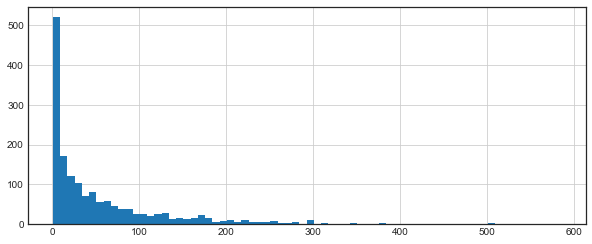

In [11]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

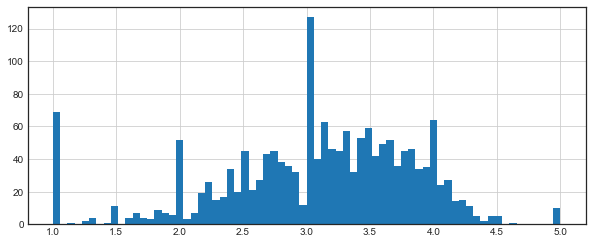

In [12]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

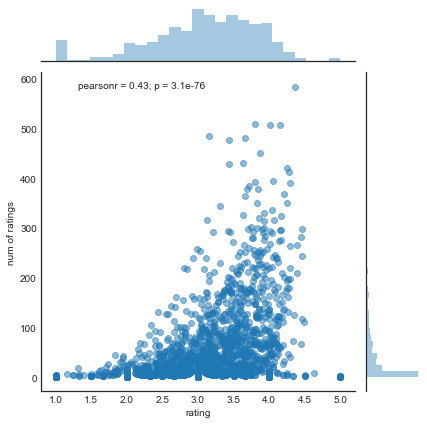

In [13]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

Okay! Jetzt wo wir ungefähr wissen, wie unsere Daten aussehen: lasst uns damit fortfahren eine einfache Empfehlung zu erstellen:

## Ähnliche Filme empfehlen

Dazu erstellen wir zuerst eine Matrix. Diese wird die User-IDs (Spalte: user_id) auf der einen Achse und die Filmtitel (Spalte: title) auf der anderen Achse tragen. Jede Zelle beinhaltet dann die Bewertung, die ein Nutzer einem Film gegeben hat. Dabei können wir gleich darauf achten, dass wir viele `NaN`-Werte erhalten werden.

In [14]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Am häufigsten bewertete Filme:

In [15]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Wählen wir nun 2 Filme: Star Wars, ein Sci-Fi Film, und Liar Liar, eine Komödie.

In [16]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Wählen wir die Bewertungen der Nutzer für diese Filme:

In [17]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

Anschließend können wir `corrwith()` verwenden, um Korrelationen zwischen den beiden Pandas Series zu erhalten:

In [18]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

/Users/davidmika/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/davidmika/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


Säubern wir das Ergebnis indem wir die NaN Werte entfernen. Außerdem können wir aus der Series einen DataFrame machen.

In [19]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Wenn wir diesen DataFrame nach den Korrelationen sortieren, dann sollten wir die ähnlichsten Filme erhalten.

Beachtet dabei, dass viele Nutzer Star Wars gesehen haben (der bekannteste Film) und andere Filme nur von einzelnen Nutzern gesehen wurden.

In [20]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
Safe Passage (1994),1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0
"Outlaw, The (1943)",1.0
"Line King: Al Hirschfeld, The (1996)",1.0


Korrigieren wir unser Ergebnis deshalb noch um die Filme die weniger als 100 Bewertungen erhalten haben. Die Grenze muss nicht 100 sein, scheint aber nach Betrachtung des Histogramms eine sinnvolle Grenze zu sein.

In [21]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Jetzt sortieren wir die Werte erneut für Filme mit mehr als 100 Bewertungen. Dieses Ergebnis wird viel mehr Sinn ergeben:

In [22]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


Das können wir auch für die Komödie Liar Liar machen:

In [23]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


# Gut gemacht!